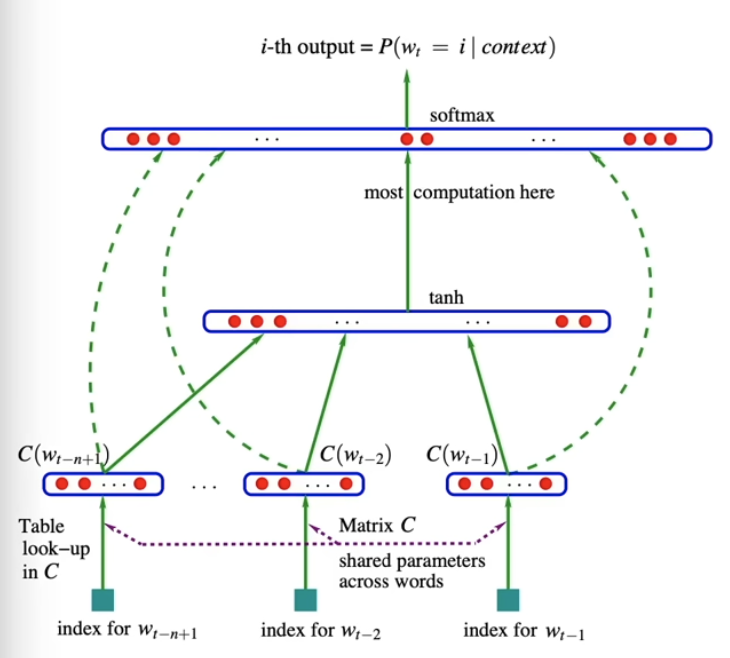

In [48]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [50]:
len(words)

32033

In [51]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [52]:
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [53]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [54]:
C = torch.randn((27, 2))

In [55]:
C[5] # get 5th row from the matrix

tensor([-0.4866,  0.1014])

In [56]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C # 5th element is one, rest is zone
# because of zero's, pluck out 5th row (only row with ones)

tensor([-0.4866,  0.1014])

In [57]:
C[X].shape # original shape 32, 3 with now 2 integers from C

torch.Size([228146, 3, 2])

In [58]:
X[13, 2] # 13th example, 2nd dimension

tensor(1)

In [59]:
C[X][13, 2]

tensor([0.6363, 0.9946])

In [60]:
C[1]

tensor([0.6363, 0.9946])

In [61]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [62]:
C = torch.randn((27,2))
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [63]:
W1 = torch.randn((6, 100)) # inputs: 3 * 2d embeddings, neurons = variable, 100 as example
b1 = torch.randn(100)

In [64]:
# emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

In [65]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [66]:
(emb.view(-1, 6) @ W1).shape

torch.Size([228146, 100])

In [67]:
b1.shape

torch.Size([100])

In [68]:
# 32 100
# 1  100
h.shape

torch.Size([228146, 100])

In [69]:
W2 = torch.randn((100, 27)) # input = 100 neurons, output = 27 possible next characters
b2 = torch.randn(27)

In [70]:
logits = h @ W2 + b2

In [71]:
logits.shape
# 100 27
# 32 100

torch.Size([228146, 27])

In [72]:
counts = logits.exp()

In [73]:
prob = counts / counts.sum(1, keepdims=True)

In [74]:
prob.shape

torch.Size([228146, 27])

In [75]:
prob[0].sum()

tensor(1.)

In [76]:
# loss = -prob[torch.arange(32), Y].log().mean() # iterate through rows of probabilties, pluck out column of Y
# negative log likelihood loss

In [77]:
# all in one place --------------------

In [158]:
g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [159]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [160]:
for p in parameters:
  p.requires_grad = True

In [161]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [174]:
lri = []
lossi = []
stepi = []

for i in range(30000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) # gradient is worse, but faster

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())


  # backward pass
  for p in parameters:
    p.grad= None
  loss.backward() # calculate gradients w.r.t. loss

  # update
  lr = 0.01
  for p in parameters:
    p.data += -0.01 * p.grad # update neurons based on gradient

  # track stats
  # lri.append(lre[i])
  lossi.append(loss.item())
  stepi.append(i)


print(loss.item())

2.930065870285034


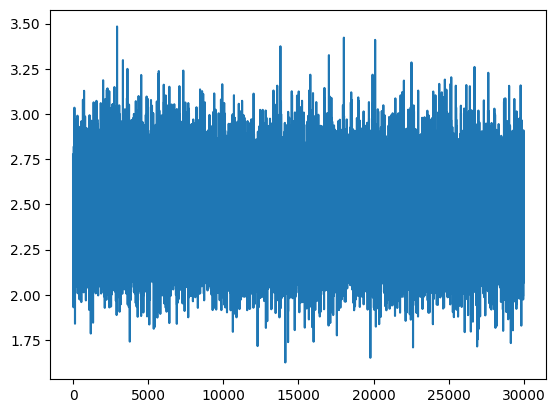

In [165]:
plt.plot(stepi, lossi)

In [176]:
# Eval
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.360273599624634

In [177]:
# Eval
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.3606066703796387

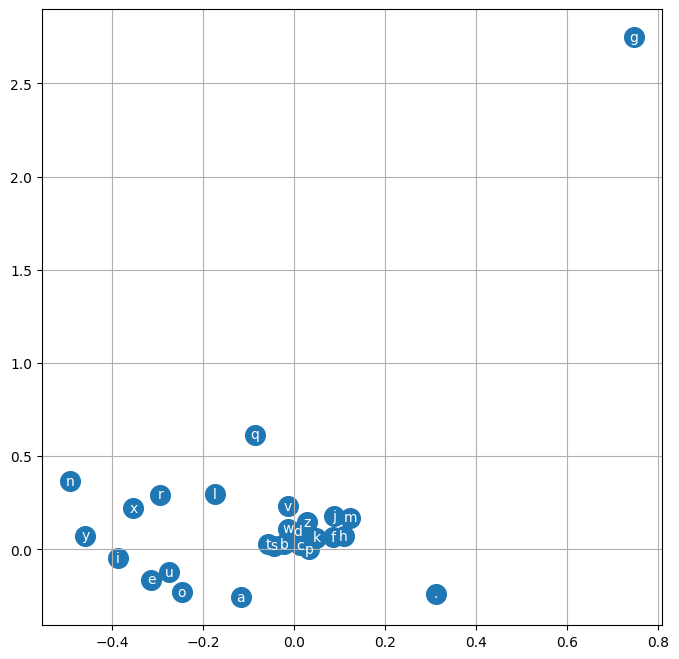

In [179]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

# next step:
# reflect on what happened and what each variable does.

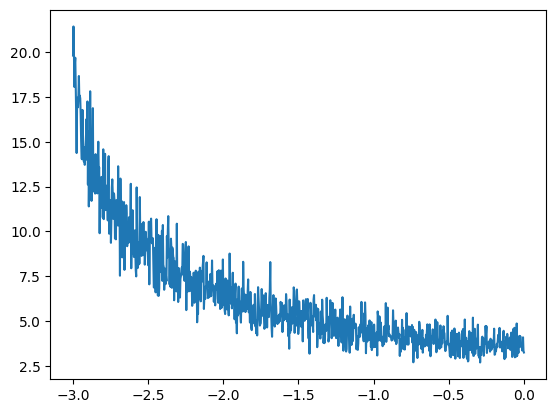

In [105]:
# How to optimize?
# 1. Find a good learning rate by trying out different values (torch.linspace)
# 2. Optimize the network using that learning rate
# 3. Decay learning rate when platue (0.1* original learning rate)

# Batching

In [83]:
torch.randint(0, 5, (32,)) # tuple of 32 of numbers between 0 and 5

tensor([3, 4, 0, 0, 3, 1, 4, 2, 4, 0, 4, 4, 0, 4, 2, 1, 3, 0, 2, 0, 0, 0, 0, 3,
        2, 1, 2, 3, 1, 3, 2, 4])

In [84]:
X.shape[0]

228146

In [85]:
torch.randint(0, X.shape[0], (32,)) # Index into our dataset based on row length

tensor([ 68758,  72520,  33230, 177526, 171716,  39536, 178406,  98859,  78825,
         83430,   9651, 104852,  50145,  19408, 193203,  81358,  59823, 169814,
         38120, 115868,  81267, 214103, 205184,   4283,  87783,  10641,  58801,
         30815, 153259,  60215, 191190,  69226])

In [86]:
 #minibatch constructs
ix = torch.randint(0, X.shape[0], (32,)) # gradient is worse, but faster

# Training

In [ ]:
# Training split, dev/validation/ test split
# 80, 10, 10
# Training split: optimize parameters of the model (gradient descent)
# Dev/validation: train hyperparameters of the model (learning rate, regulatization, etc.)
# Test split: Evaluate performance of the model on the end

In [137]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) # first 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # next 10%
Xte, Yte = build_dataset(words[n2:]) # last 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
